Forecasting initial tests to see how correlated the data is, i.e. auto correlation.

In [1]:
import os 
import sys
sys.path.append('/home/amey/Projects/BUKO_Forecasting/Modelling/model')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import processing
import importlib
import forecasting_functions as ff
dirname='/home/amey/Projects/BUKO_Forecasting/'

Focussing on 3 locations

Rotterdam, Amsterdam Denhaag may be beverwijk?
Let us start with Ahek.

In [16]:
artikel_code='AHEK'
# artikel_code= 'TB80120G'
region='Rotterdam'
# region='Beverwijk'
start_year=2007
file_loc=dirname+'Modelling/processed_data/'
file_loc=file_loc+region

day_file=os.path.join(file_loc,artikel_code+'_week'+str(start_year)+'.csv')
df_day=pd.read_csv(day_file,header=0,sep=',',on_bad_lines='warn')
print(df_day.keys())
day_ts=df_day['Net_week_art']
timevec=df_day['Date']

Index(['Unnamed: 0', 'Date', 'Net_week_art'], dtype='object')


In [17]:


# # day_ts.index=pd.to_datetime(timevec.values)
# #manco
# manco_file=os.path.join(file_loc,'running_manco_ahek_rotterdam.csv')
# df_manco=pd.read_csv(manco_file,header=0,sep=',',on_bad_lines='warn')
# manco_ts=df_manco['Running Manco Sum']
# day_ts=day_ts-manco_ts
# # day_ts.values=day_ts1
day_ts.index=pd.to_datetime(timevec.values)

Start with a training time series

In [27]:
nyears=int(3)
start=int(5*52+0)
train_ts=day_ts[start:start+52*8+2]
print(train_ts.index)

DatetimeIndex(['2012-01-08', '2012-01-15', '2012-01-22', '2012-01-29',
               '2012-02-05', '2012-02-12', '2012-02-19', '2012-02-26',
               '2012-03-04', '2012-03-11',
               ...
               '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29', '2020-01-05'],
              dtype='datetime64[ns]', length=418, freq=None)


0.9600277328456568
0.6641049007885186
0.6954029149740691
0.6521912643777535
0.5670570890065649


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

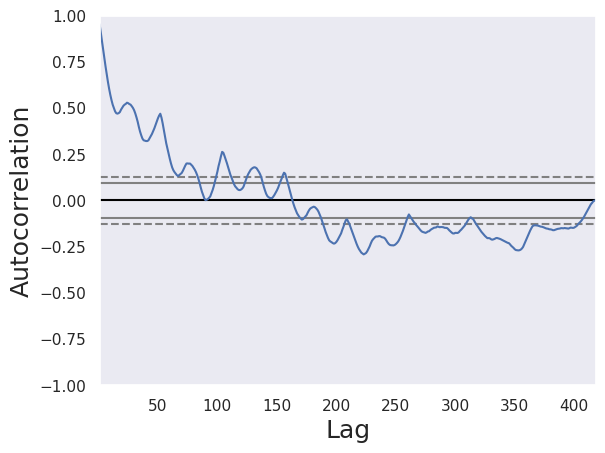

In [28]:
lagvec=[1,25,52,52*2,int(52*2.5)]
for lag in lagvec:
    x=train_ts.autocorr(lag=lag)
    print(x)
pd.plotting.autocorrelation_plot(train_ts)

Based on the above we believe there is a nice seasonality and trend

Let us start with  a seasonal decomposition

<Figure size 1200x1200 with 0 Axes>

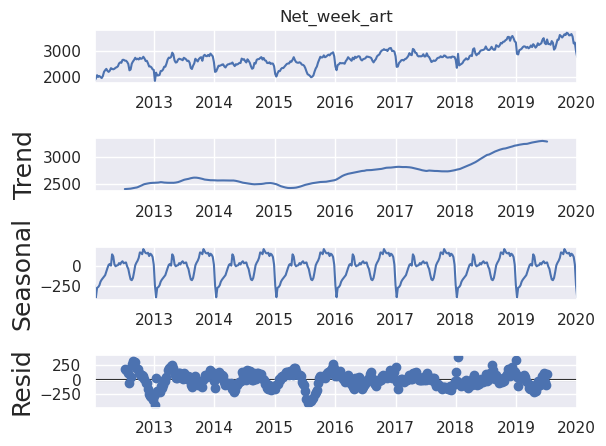

In [31]:
import statsmodels.api as sm
result=sm.tsa.seasonal_decompose(train_ts,model='add',period=52*1)
fig=plt.figure(figsize=(12,12))
fig=result.plot()

In [55]:
result.resid

2015-01-11   NaN
2015-01-18   NaN
2015-01-25   NaN
2015-02-01   NaN
2015-02-08   NaN
              ..
2019-12-08   NaN
2019-12-15   NaN
2019-12-22   NaN
2019-12-29   NaN
2020-01-05   NaN
Name: resid, Length: 261, dtype: float64

measure of seasonality and trend
ref: https://otexts.com/fpp2/seasonal-strength.html

In [25]:
ff.compute_coeff_trend_seasonality(result)

0.5712187110397055
0.5207014213321333


Exponential smoothing algorithm is used with holtwinters.

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


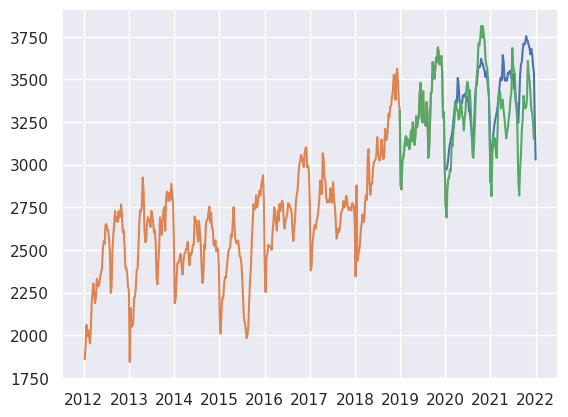

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# train_ts=day_ts[start:start+52*2+0]
exphwf=ExponentialSmoothing(train_ts,damped_trend=False,trend='add',seasonal='add',seasonal_periods=52*1,initialization_method='estimated')
expwf_res=exphwf.fit()
forecast=expwf_res.forecast(52*2)
plt.plot(forecast)
plt.plot(train_ts)
plt.plot(day_ts[start+52*6+52:start+52*9+52])


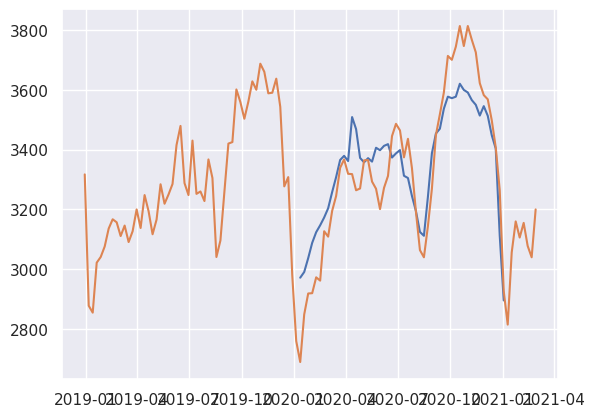

In [32]:
plt.plot(expwf_res.forecast(52))
plt.plot(day_ts[start+52*7:start+52*9+10])

In [64]:
exphwf.params

{'smoothing_level': 0.49999987503251875,
 'smoothing_trend': 0.00010177176612301034,
 'smoothing_seasonal': 0.00010178404771249418,
 'damping_trend': nan,
 'initial_level': 3214.393556451923,
 'initial_trend': -0.03401019081701292,
 'initial_seasons': array([0.88278253, 0.88548448, 0.88945109, 0.88992891, 0.88659076,
        0.90951659, 0.92931047, 0.93530708, 0.94212706, 0.93835767,
        0.94232912, 0.93914153, 0.9599728 , 0.95487978, 0.96058669,
        0.96351063, 0.96507222, 0.94488733, 0.93628932, 0.94499997,
        0.95810168, 0.96965622, 0.96955318, 0.97459135, 0.96641762,
        0.95619347, 0.9672906 , 0.97489084, 0.98212679, 0.98284159,
        0.99398235, 0.9846901 , 0.9730145 , 0.97806872, 0.99523579,
        0.99272239, 0.9924293 , 0.99015336, 0.98709083, 0.98585379,
        0.99860399, 1.00446028, 1.01199166, 1.02068213, 1.02193914,
        1.00651365, 0.98873925, 0.99852683, 1.00075198, 1.00631676,
        1.01173094, 1.01740495, 1.00254155, 0.98857643, 1.01105064,
 

In [32]:
exphwf._estimate_trend

Below tests were wtith STL and ARIMA but exponential works better in this case, 

In [246]:
from statsmodels.tsa.seasonal import STL
stl=STL(train_ts)

In [312]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [338]:
stlf=STLForecast(train_ts, ARIMA, model_kwargs=dict(order=(2, 0, 0), trend=[1,1,]))
stlf_res=stlf.fit()
forecast=stlf_res.forecast(360)

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


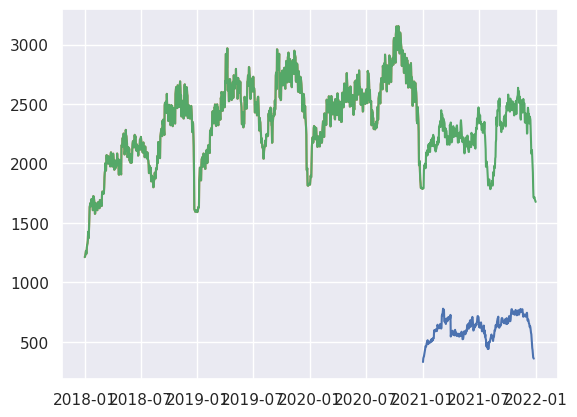

In [511]:
plt.plot(forecast)
plt.plot(train_ts)
plt.plot(day_ts[start:start+365*5+361])

In [373]:
arimaf=ARIMA(train_ts,order=(3,0,0),seasonal_order=(0, 0, 0,365), trend=[1,1,1])
arima_res=arimaf.fit()
forecast=arima_res.forecast(360)

/home/amey/anaconda3/envs/buko_infra/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


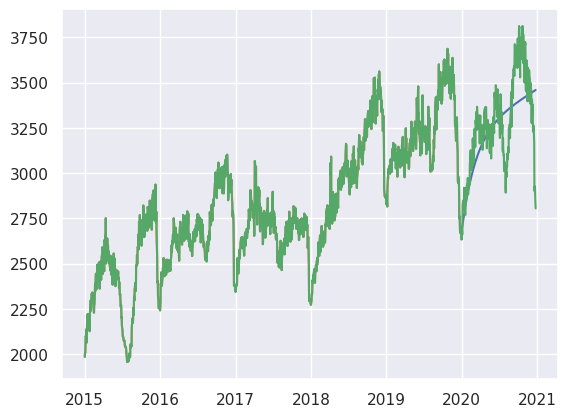

In [374]:
plt.plot(forecast)
plt.plot(train_ts)
plt.plot(day_ts[start:start+365*5+361])

result.trend